# Improving Starbucks Offer Targeting with Redemption Prediction

## 03. Redemption and Expected Spend Prediction

This is the third & final notebook out of 3 which details the steps taken to:
1. Tune and select a classifier that predicts redemption
2. Tuning and selecting a regressor that predicts expected spend if redeemed 
3. Combine both to output an understandable ranking of offers

<b> Content </b>
- [0. Recap of Variables](#section0)
- [1. Prepare Dataset](#section1)
    - [1.1 Encode Categorical Variables](#section1.1)
- [2. Predicting Offer Redemption through Classfication](#section2)
    - [2.1 Create Train-Test Split & Evaluation Helper Functions](#section2.1)
    - [2.2 Logistic Regression](#section2.2)
    - [2.3 Support Vector Machine](#section2.3)
    - [2.4 Random Forest Classifier](#section2.4)
    - [2.5 XGBoost Classifier](#section2.5)
    - [2.6 Classifier Evaluation & Selection](#section2.6)
    - [2.7 Findings: The Most Important Features Predicting Offer Success](#section2.7)
- [3. Predicting Amount Spent through Regression](#section3)
    - [3.1 Create Train-Test Split and Evaluation Functions](#section3.1)
    - [3.2 Linear Regression](#section3.2)
    - [3.3 Random Forest Regressor](#section3.3)
    - [3.4 K-Nearest Neighbours Regressor](#section3.4)
    - [3.5 Regressor Evaluation & Selection](#section3.5)
    - [3.6 Findings: The Most Important Features Predicting Amount Spent](#section3.6)
- [4. Combined Expected Value Model](#section4)
    - [4.1 Offer Ranking Using Trained Models](#section4.1)

In [1]:
# Import numerical libraries
import numpy as np
import pandas as pd

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import pre-processing functions
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Import tuning functions
from sklearn.model_selection import train_test_split, GridSearchCV

# Import classifiers & regressors
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Import evaluation functions
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
                            ConfusionMatrixDisplay,roc_auc_score, roc_curve, recall_score,mean_squared_error 
from sklearn.datasets import make_circles
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

## 0. Recap of Variables<a class="anchor" id="section0"></a>

This data was already processed in Notebook *01.Data Preprocessing*.

- *person*: Alphanumeric identifier of a customer
- *offer_id*: Alphanumeric identifier of an offer
- *journey*: Alphanumeric identifier of an end-to-end offer lifecycle
- *days*: Days since data collection has commenced
- *offer received, viewed, completed*: 0 if True, 1 if False
- *gender*: Male (M), Female (F) or Others (O)
- *age*: Numeric value for age
- *reward*: The number of reward points (stars*) awarded for completion of an offer
- *difficulty*: Minimum spend required to complete offer
- *duration*: Days that offer is valid for
- *offer type*: Buy-one-get-one (bogo), informational or direct discount
- *channels*: Communication channels that offer was delivered over, split into dummy 
- *promo_name*: Promotion configuration identifier
- *amount*: Transaction amount
- *catcoding*: Combination of offer received-offer viewed-offer completed as per the table below
- *scenario_description*: User-friendly description of *catcoding* as per the table below

<img src = "./images/customerjourneywstatus.png" width="700"/>

In [2]:
# Import and view data
df_all = pd.read_csv('data/preprocessed_data.csv')
df_all.columns

Index(['person', 'offer_id', 'journey', 'days', 'offer received',
       'offer viewed', 'offer completed', 'gender', 'age', 'income',
       'member_duration', 'reward', 'difficulty', 'duration', 'offer_type',
       'channel_web', 'channel_mobile', 'channel_social', 'promo_name',
       'amount', 'catcoding', 'scenario_description'],
      dtype='object')

## 1. Prepare Dataset<a class="anchor" id="section1"></a>

### 1.1 Encode Categorical Variables <a class="anchor" id="section1.1"></a>

First, create a dummy column with the classification target variable *Success*. If offer was received, seen and completed, then *Success* = 1, else 0.

In [3]:
# Add a binary success / failure column
df_all['success'] = np.where(df_all["scenario_description"] == 'success',1,0)

Secondly, create dummies for categorical columns.

- *gender_dum_M*: 0 if Female, 1 if Male
- *offer_type_dum_discount*: 0 if buy-one-get-one, 1 if discount

In [4]:
# Copy the dummy columns to preserve them
df_all[['offer_type_dum', 'gender_dum']] = df_all[['offer_type','gender']]

# Use newly created columns in get_dummies (original columns will be dropped)
dummies_needed = ['gender_dum', 'offer_type_dum']

# Ensure to drop_first = True to prevent multicollinearity issues
df_all = pd.get_dummies(data=df_all, columns=dummies_needed, drop_first=True, prefix_sep='_')

In [5]:
df_all.head()

,person,offer_id,journey,days,offer received,offer viewed,offer completed,gender,age,income,...,channel_web,channel_mobile,channel_social,promo_name,amount,catcoding,scenario_description,success,gender_dum_M,offer_type_dum_discount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,24.00,1,0,1,M,33,72000.0,...,1,1,0,disc-1,10.27,1-0-1,"failed, completed",0,1,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,30,17.00,1,0,0,F,19,65000.0,...,1,1,0,disc-1,0.00,1-0-0,"failed, not seen",0,0,1
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,31,24.00,1,0,0,F,19,65000.0,...,1,1,0,disc-1,0.00,1-0-0,"failed, not seen",0,0,1
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,43,17.00,1,0,0,M,56,47000.0,...,1,1,0,disc-1,0.00,1-0-0,"failed, not seen",0,1,1
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,65,22.25,1,0,1,F,58,119000.0,...,1,1,0,disc-1,21.35,1-0-1,"failed, completed",0,0,1


## 2. Predicting Offer Redemption through Classfication<a class="anchor" id="section2"></a>

#### Target Variable: *success* (binary)

In this section, we train and select a classifier that helps to predict offer success. This will help to identify which offers are most likely to be redeemed by a particular customer.

### 2.1 Create Train-Test Split & Evaluation Helper Functions<a class="anchor" id="section2.1"></a>

30% of data is withheld as the test set.

In [6]:
y = df_all['success']

features = ['age', 'income', 'member_duration','reward', 'difficulty', 
        'days', 'channel_web', 'channel_mobile', 
        'channel_social', 'gender_dum_M', 'offer_type_dum_discount']

X = df_all[features]

# Define train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)


In [7]:
# Define a comprehensive classification summary for easy checking

def classification_summary(X_train, X_test, y_train, y_test, model_name, model_name_text):
    
    y_pred_test = model_name.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred_test, labels=model_name.classes_)

    # Compute all metrics manually
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]

    tpr = tp/(tp+fn)
    fnr = 1 - tpr

    tnr = tn/(tn+fp)
    fpr = 1-tnr

    print('Test Set Metrics')
    print('{} Plain Accuracy:{}%'.format(model_name_text,
                                         round(accuracy_score(y_test, y_pred_test)*100,2)))
    print('TPR:{}%'.format(round(tpr*100,2)))
    print('FNR:{}%'.format(round(fnr*100,2)))
    print('TNR:{}%'.format(round(tnr*100,2)))
    print('FPR:{}%'.format(round(fpr*100,2)))
    print('Recall:{}%'.format(round(recall_score(y_test, y_pred_test)*100,2)))
    print('Precision:{}%'.format(round(precision_score(y_test, y_pred_test)*100,2)))
    print('AUC Score:{}'.format(round(roc_auc_score(y_test,y_pred_test),3)))
    print('')
    
    # Compute train set accuracy
    print('Train Set Metrics')
    y_pred_train = model_name.predict(X_train)
    print('{} Plain Accuracy:{}%'.format(model_name_text,
                                         round(accuracy_score(y_train, y_pred_train)*100,2)))
    print('Recall:{}%'.format(round(recall_score(y_train, y_pred_train)*100,2)))
    print('Precision:{}%'.format(round(precision_score(y_train, y_pred_train)*100,2)))
    print('AUC Score:{}'.format(round(roc_auc_score(y_train,y_pred_train),3)))    
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_name.classes_)
    disp.plot()
    plt.show()
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model_name.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    fig, ax = plt.subplots(figsize=[8,6])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ({})'.format(model_name_text), fontsize = 20)
    plt.show()

### 2.2 Logistic Regression<a class="anchor" id="section2.2"></a>

#### 2.2.1 Hyperparameter Tuning

Hyperparameters are tuned using 5-fold cross validation.

In [8]:
param_grid = {
     'penalty' : ['l1', 'l2'],
    'C' : [0.001, 0.1, 1, 5, 10, 20, 50], #default = 1
    'solver' : ['liblinear']}

# Instantiate the GridSearchCV object
model = LogisticRegression()
lr_cv = GridSearchCV(model, param_grid, cv=5)
lr_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(lr_cv.best_params_)) 
print("Best score is {}".format(lr_cv.best_score_))

Tuned Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best score is 0.6737011155502943


#### 2.2.2 Train Model & Inspect Performance on Test Set

Pass the best parameters into Logistic Regression model and obtain test score. 

Test Set Metrics
Logistic Regression Plain Accuracy:67.19%
TPR:51.46%
FNR:48.54%
TNR:78.56%
FPR:21.44%
Recall:51.46%
Precision:63.44%
AUC Score:0.65

Train Set Metrics
Logistic Regression Plain Accuracy:67.42%
Recall:52.53%
Precision:63.49%
AUC Score:0.654


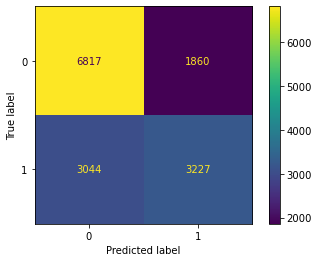

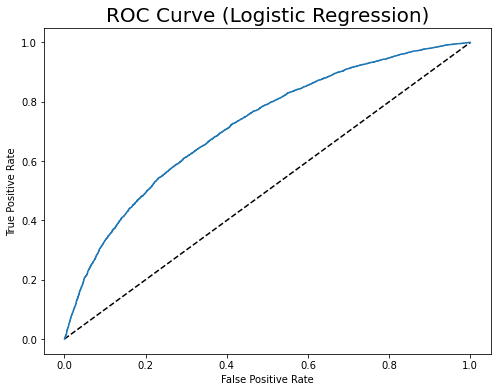

In [9]:
logreg = LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear')
logreg.fit(X_train, y_train)

classification_summary(X_train = X_train, 
                       X_test = X_test,
                       y_train = y_train, 
                       y_test = y_test, 
                       model_name = logreg, 
                       model_name_text = 'Logistic Regression')

### 2.3 Support Vector Machine<a class="anchor" id="section2.3"></a>

#### 2.3.1 Perform Feature Scaling

Features must first be scaled because having inconsistent scales for different features distorts the closeness of each observation, with some features having more influence than others.

- Binary variables are not scaled
- After scaling, scaled variables have mean of 0 and standard deviation of 1

In [10]:
# Create a ColumnTransformer helper
scale_cols = ['age', 'income', 'member_duration', 'reward', 'difficulty', 'days']
ct = ColumnTransformer([('transformer', StandardScaler(), scale_cols)], 
                       remainder='passthrough')


# Scale the Train Set and check summary statistics
X_train_scaled = X_train.copy()
X_train_scaled = pd.DataFrame(ct.fit_transform(X_train_scaled), 
                              columns = features) # features used to define X_train
X_train_scaled.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
age,34876.0,-0.00,1.00,-2.17,-0.67,0.08,0.76,1.89
income,34876.0,0.00,1.00,-1.63,-0.75,-0.10,0.64,2.53
member_duration,34876.0,-0.00,1.00,-1.24,-0.75,-0.40,0.66,3.10
reward,34876.0,0.00,1.00,-1.09,-1.09,-0.08,1.58,1.58
difficulty,34876.0,0.00,1.00,-1.05,-0.60,0.08,0.08,2.34
days,34876.0,0.00,1.00,-1.89,-0.89,0.19,0.82,1.69
channel_web,34876.0,0.87,0.33,0.00,1.00,1.00,1.00,1.00
channel_mobile,34876.0,0.88,0.33,0.00,1.00,1.00,1.00,1.00
channel_social,34876.0,0.63,0.48,0.00,0.00,1.00,1.00,1.00
gender_dum_M,34876.0,0.59,0.49,0.00,0.00,1.00,1.00,1.00


In [11]:
# Scale the Test Set and check summary statistics
X_test_scaled = X_test.copy()
X_test_scaled = pd.DataFrame(ct.fit_transform(X_test_scaled), columns = features)
X_test_scaled.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
age,14948.0,0.00,1.00,-2.16,-0.73,0.09,0.77,1.90
income,14948.0,-0.00,1.00,-1.63,-0.75,-0.10,0.65,2.56
member_duration,14948.0,-0.00,1.00,-1.24,-0.75,-0.39,0.65,3.07
reward,14948.0,-0.00,1.00,-1.09,-0.76,-0.08,-0.08,1.61
difficulty,14948.0,0.00,1.00,-1.03,-1.03,0.08,0.08,2.30
days,14948.0,-0.00,1.00,-1.91,-0.88,0.18,0.85,1.70
channel_web,14948.0,0.87,0.33,0.00,1.00,1.00,1.00,1.00
channel_mobile,14948.0,0.87,0.34,0.00,1.00,1.00,1.00,1.00
channel_social,14948.0,0.62,0.49,0.00,0.00,1.00,1.00,1.00
gender_dum_M,14948.0,0.59,0.49,0.00,0.00,1.00,1.00,1.00


#### 2.3.2 Hyperparameter Tuning

Hyperparameters are tuned using 5-fold cross validation.

In [12]:
# Kernel to be tuned in the following
C = [0.1, 1, 10, 50]
kernel = ['poly','rbf','sigmoid']

param_grid = {'C': C, #default = 1
              'kernel': kernel} #default = RBF

# Instantiate the GridSearchCV object
model = SVC(random_state = 42) # default kernel = rbf
cv = GridSearchCV(model, param_grid, cv=5, n_jobs = -1)
cv.fit(X_train_scaled,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(cv.best_params_)) 
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'C': 10, 'kernel': 'rbf'}
Best score is 0.7048686700535991


#### 2.3.3 Train Model & Inspect Performance on Test Set

Pass the best parameters into Support Vector Classifier and obtain test score. 

Test Set Metrics
Support Vector Machine Plain Accuracy:70.23%
TPR:54.49%
FNR:45.51%
TNR:81.61%
FPR:18.39%
Recall:54.49%
Precision:68.16%
AUC Score:0.68

Train Set Metrics
Support Vector Machine Plain Accuracy:71.21%
Recall:56.06%
Precision:69.43%
AUC Score:0.691


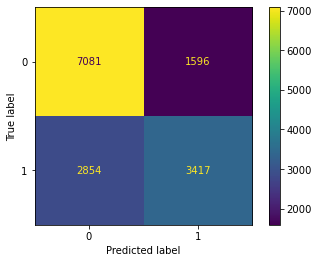

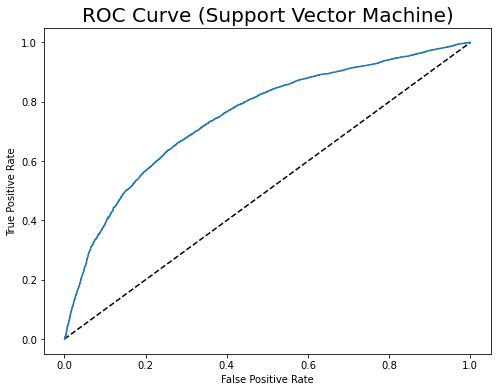

In [13]:
svm = SVC(probability = True, C = 10, gamma = 'scale', kernel = 'rbf')
svm.fit(X_train_scaled, y_train)

classification_summary(X_train = X_train_scaled, 
                       X_test = X_test_scaled,
                       y_train = y_train, 
                       y_test = y_test, 
                       model_name = svm, 
                       model_name_text = 'Support Vector Machine')

### 2.4 Random Forest Classifier<a class="anchor" id="section2.4"></a>

#### 2.4.1 Hyperparameter Tuning

Hyperparameters are tuned using 5-fold cross validation. Due to time constraints, parameters are tuned in two steps rather than in 1 go. Random Search CV can also be used.

In [14]:
# Number of trees in ensemble, default = 100
n_estimators = [100, 300, 500, 1000]

# Min samples in leaf, default = 1
min_samples_leaf = [1, 5, 25, 50]
param_grid = {'n_estimators': n_estimators,
             'min_samples_leaf': min_samples_leaf }

# Instantiate the GridSearchCV object
model = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state =42)
rfc_cv = GridSearchCV(model, param_grid, cv=5)
rfc_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

Tuned Parameters: {'min_samples_leaf': 5, 'n_estimators': 500}
Best score is 0.7249112697708067


In [15]:
# Fix min_samples_leaf and n_estimators and tune others
max_depth = [1, 3, 6, 10, 15] #default = 0
min_samples_split = [25, 100, 150, 200] #default = 2

model = RandomForestClassifier(oob_score = True, 
                               n_jobs = -1, 
                               random_state = 42,
                              min_samples_leaf = 5,
                              n_estimators = 500)

param_grid = {'max_depth': max_depth, #default is 6
             'min_samples_split': min_samples_split, #default is 100
             }

rfc_cv = GridSearchCV(model, param_grid, cv=5)
rfc_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

Tuned Parameters: {'max_depth': 15, 'min_samples_split': 25}
Best score is 0.7243951571799678


#### 2.4.2 Train Model & Inspect Performance on Test Set

Pass the best parameters into Random Forest Classifier and obtain test score. 

Test Set Metrics
Random Forest Plain Accuracy:72.78%
TPR:60.74%
FNR:39.26%
TNR:81.48%
FPR:18.52%
Recall:60.74%
Precision:70.33%
AUC Score:0.711

Train Set Metrics
Random Forest Plain Accuracy:78.98%
Recall:69.08%
Precision:78.26%
AUC Score:0.776


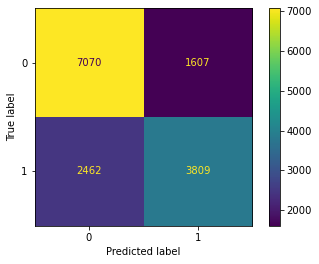

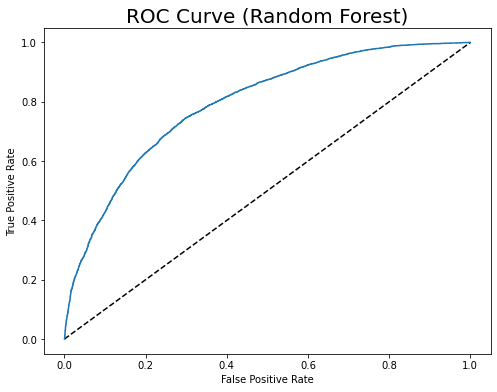

In [16]:
# p (number of features) is set at default as there is little difference in the various methods

rfc = RandomForestClassifier(random_state = 42, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 5, 
                             n_estimators = 500,
                            max_depth = 15,
                            min_samples_split = 25)
rfc.fit(X_train, y_train)

classification_summary(X_train = X_train, 
                       X_test = X_test,
                       y_train = y_train, 
                       y_test = y_test, 
                       model_name = rfc, 
                       model_name_text = 'Random Forest')

### 2.5 XGBoost Classifier<a class="anchor" id="section2.5"></a>

#### 2.5.1 Hyperparameter Tuning

Hyperparameters are tuned using 5-fold cross validation. Due to time constraints, parameters are tuned in two steps rather than in 1 go. Random Search CV can also be used.

In [17]:
max_depth = [3, 6, 10]
n_estimators = [100, 300, 500]

param_grid = {'max_depth': max_depth, #default is 6
             'n_estimators': n_estimators, #default is 100
             }

# Instantiate the GridSearchCV object
model = XGBClassifier(use_label_encoder=False, random_state = 42, 
                      eval_metric='auc',
                     objective = 'binary:logistic')

cv = GridSearchCV(model, param_grid, cv=5, n_jobs = -1)
cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(cv.best_params_)) 
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'max_depth': 3, 'n_estimators': 100}
Best score is 0.7461577554174477


In [18]:
# Fix max_depth and n_estimators and tune others
colsample_bytree = [0.1, 0.3, 0.7, 1] #default = 0.3
gamma = [0.1, 0.3, 0.7, 1] #default = 0

param_grid = {'colsample_bytree': colsample_bytree, #default is 6
             'gamma': gamma, #default is 100
             }

# Instantiate the GridSearchCV object
model = XGBClassifier(use_label_encoder=False, random_state = 42, 
                      eval_metric='auc',
                     objective = 'binary:logistic',
                     max_depth = 3,
                     n_estimators = 100)

cv = GridSearchCV(model, param_grid, cv=5, n_jobs = -1)
cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(cv.best_params_)) 
print("Best score is {}".format(cv.best_score_))

Tuned Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1}
Best score is 0.7484230377166157


#### 2.5.2 Train Model & Inspect Performance on Test Set

Pass the best parameters into XGBoost and obtain test score. 

Test Set Metrics
XGBoost Plain Accuracy:74.92%
TPR:68.67%
FNR:31.33%
TNR:79.44%
FPR:20.56%
Recall:68.67%
Precision:70.71%
AUC Score:0.741

Train Set Metrics
XGBoost Plain Accuracy:75.93%
Recall:69.35%
Precision:72.18%
AUC Score:0.75


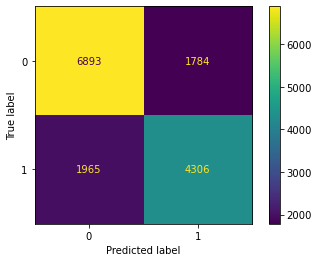

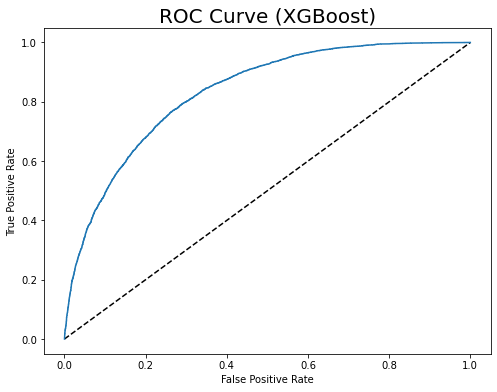

In [19]:
xgb = XGBClassifier(use_label_encoder=False, random_state = 42, 
                    eval_metric='auc',
                    objective = 'binary:logistic',
                    max_depth = 3,
                    n_estimators = 100, 
                    colsample_bytree = 0.7, 
                    gamma = 0.1)

xgb.fit(X_train, y_train)

classification_summary(X_train = X_train, 
                       X_test = X_test,
                       y_train = y_train, 
                       y_test = y_test, 
                       model_name = xgb, 
                       model_name_text = 'XGBoost')

### 2.6 Classifier Evaluation & Selection<a class="anchor" id="section2.6"></a>

#### Best Performance: XGBoost Classifier

Overall, we should proceeed with XGBoost Classifier to predict offer redemption given as it has the highest precision, recall, AUC and accuracy by a long shot.

<b>Key Observations</b>

- From the Exploratory Data Analysis (EDA) is known that only 42% of all offers sent out are successfully seen & completed
- XGBoost (and arguable any classifier) will be able to improve upon this significantly, to 71%, represeting <b>+29% improvement</b> (from the precision metric) 
- Logistic Regression generally performed the worst, strongly suggesting that a linear decision boundary may not be the best fit for offer sucess. 

Each classifiers' performance is summarised below, with best performance in green and worst in red. Test Set metrics are what are used for evaluation and Train Set is included for reference only.

<img src = "./images/classifier_results.png" width="600"/>

The ROC Curve further reinforces this as Random Forest and XGBoost visibly have the maximum area under curve (AUC).



<Figure size 432x288 with 0 Axes>

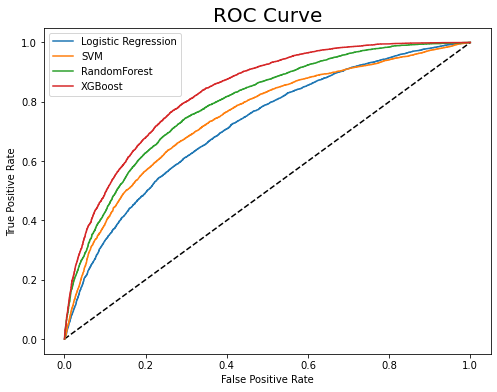

In [20]:
dict_classifiers = {
    "Logistic Regression": logreg,
    "SVM": svm,
    "RandomForest": rfc,
    "XGBoost": xgb
}

plt.clf()

fig, ax = plt.subplots(figsize=[8,6])
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

lines = []

for i, (model, model_instantiation) in enumerate(dict_classifiers.items()):
    # Compute predicted probabilities: y_pred_prob
    
    if model == 'SVM':
        y_pred_prob = model_instantiation.predict_proba(X_test_scaled)[:,1]
    
    else:
        y_pred_prob = model_instantiation.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Plot ROC curve
    # plt.plot(fpr, tpr)
    lines += plt.plot(fpr,tpr, label="{}".format(model))

# Create manual labelling
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)
plt.show()

### 2.7 Findings: The Most Important Features Predicting Offer Success<a class="anchor" id="section2.7"></a>

With opaque classifiers like XGBoost, it is useful to use <b>permutation feature imporance</b> to see which features are most impactful. 

In a nutshell, this metric tells us which features, if present, are most likely to result in a better classification outcome. Refer to sklearn's insightful summary on [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html).

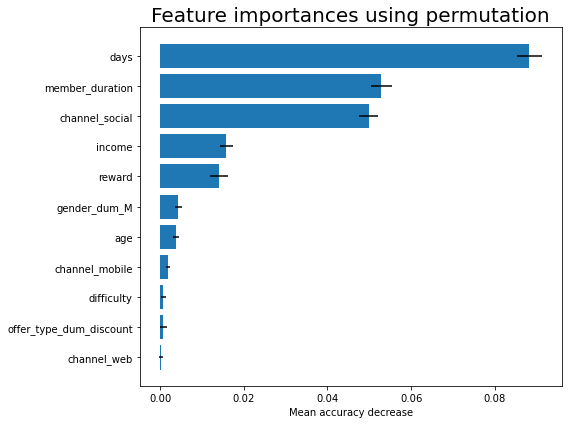

In [21]:
result = permutation_importance(
    xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

feature_names = [f"{i}" for i in X.columns]
importances = result.importances_mean
std = result.importances_std

my_dict = {'feature_names': feature_names, 'feature_impt': importances, 'std': std}

pi = pd.DataFrame.from_dict(my_dict)
pi.sort_values(by = 'feature_impt', ascending = False, inplace = True)

# Visualize feature importances
fig, ax = plt.subplots(figsize=[8,6])
plt.barh(y = pi['feature_names'], width = pi['feature_impt'], xerr=pi['std'])
ax.set_title("Feature importances using permutation", fontsize = 20)
ax.set_xlabel("Mean accuracy decrease")
ax.invert_yaxis()  # labels read top-to-bottom
fig.tight_layout()

#### The 3 Most Important Features Predicting Offer Completion

We can clearly see that the top 3 most important factors in whether or not a promotion is redeemed are *days*, *member_duration* and *channel_social* (social media targeting).

This is valuable information from a marketing perspective as one may reasonably conclude that:
1. <b>Long-time members may be more likely to redeem promotions</b> and should be more heavily targeted, whereas members in other age groups may need to be engaged in other ways.
2. <b>Sharing the promotion across social media is important</b>, suggesting that other distribution channels (website/ mobile app) were not so effective.

As for the importance of *days*, this may be because offers are sent in bursts through the month. Hence, the closer the date is to those bursts, the higher likelihood of offer success. It may be that as time elapses without an offer completion, customers are more likely to have seen but are ignoring the offer. 

## 3. Predicting Amount Spent through Regression<a class="anchor" id="section3"></a>

#### Target Variable: *amount* (binary)

In this section, we train and select a regressor that helps to predict amount spent <b>given offer success</b>. This will help to assign an expected spend value to each expected offer redemption.


### 3.1 Create Train-Test Split and Helper Functions<a class="anchor" id="section3.1"></a>

30% of data is withheld as the test set. Only data where an offer has been successful is used for model training as we are only concerned with the conditional amount spent given a succesful offer.

In [22]:
# Select only success scenarios
df_reg = df_all[df_all['success']==1]

y_reg = df_reg['amount']

features = ['age', 'income', 'member_duration','reward', 'difficulty', 
        'days', 'channel_web', 'channel_mobile', 
        'channel_social', 'gender_dum_M', 'offer_type_dum_discount']

X_reg = df_reg[features]

# Define train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

A helper function is also created to easily print regression scores, using mean squared error (MSE) as the success metric.

In [23]:
# Helper function to print scores

def regression_scores(model, X_train, X_test, y_train, y_test):
    
    pred_train= model.predict(X_train)
    pred_test= model.predict(X_test)
    
    train_MSE = mean_squared_error(y_train, pred_train)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('R2 train', round(model.score(X_train, y_train),2))
    print('Train MSE:', round(train_MSE,2))
    print('')
    print('R2 test', round(model.score(X_test, y_test),2))
    print('Test MSE:', round(test_MSE,2))

### 3.2 Linear Regression<a class="anchor" id="section3.2"></a>

Fit a simple linear regression to get a baseline.

In [24]:
lr = LinearRegression()
lr.fit(X_train_reg,y_train_reg)

regression_scores(lr, X_train_reg, X_test_reg, y_train_reg, y_test_reg)

R2 train 0.46
Train MSE: 39.42

R2 test 0.47
Test MSE: 39.05


### 3.3 Random Forest Regressor<a class="anchor" id="section3.3"></a>

#### 3.3.1 Hyperparameter Tuning

Hyperparameters are tuned using 5-fold cross validation. Due to time constraints, parameters are tuned in two steps rather than in 1 go. Random Search CV can also be used.

In [25]:
# Number of trees in ensemble, default = 100
n_estimators = [100, 300, 500, 1000]

# Min samples in leaf, default = 1
min_samples_leaf = [25, 50, 100, 200]
param_grid = {'n_estimators': n_estimators,
             'min_samples_leaf': min_samples_leaf}

# Instantiate the GridSearchCV object
model = RandomForestRegressor(n_jobs = -1, random_state =42)
rfr_cv = GridSearchCV(model, param_grid, cv=5)
rfr_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(rfr_cv.best_params_)) 
print("Best score is {}".format(rfr_cv.best_score_))

Tuned Parameters: {'min_samples_leaf': 25, 'n_estimators': 1000}
Best score is 0.2835803732150929


In [26]:
# Fix n_estimators and min_samples_leaf and tune depth
m_depth = [1,3,6,10,15]

param_grid = {'max_depth': m_depth}

# Instantiate the GridSearchCV object
model = RandomForestRegressor(n_jobs = -1, random_state =42,min_samples_leaf = 25, n_estimators = 1000)
rfr_cv = GridSearchCV(model, param_grid, cv=5)
rfr_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Parameters: {}".format(rfr_cv.best_params_)) 
print("Best score is {}".format(rfr_cv.best_score_))

Tuned Parameters: {'max_depth': 15}
Best score is 0.28231903186834667


#### 3.3.2 Train Model & Inspect Performance on Test Set

Pass the best parameters into Random Forest and obtain test score. 

In [27]:
rfr = RandomForestRegressor(n_jobs = -1, random_state =42, 
                            min_samples_leaf = 25, 
                            n_estimators = 1000,
                           max_depth = 15)

rfr.fit(X_train_reg,y_train_reg)

regression_scores(rfr, X_train_reg, X_test_reg, y_train_reg, y_test_reg)

R2 train 0.57
Train MSE: 31.73

R2 test 0.5
Test MSE: 36.51


### 3.4 K-Nearest Neighbours Regressor<a class="anchor" id="section3.4"></a>

#### 3.4.1 Selection of Optimal K

Using the elbow method, we visually select <b>K = 15</b> as the point where gain in accuracy from that point onwards is marginal.

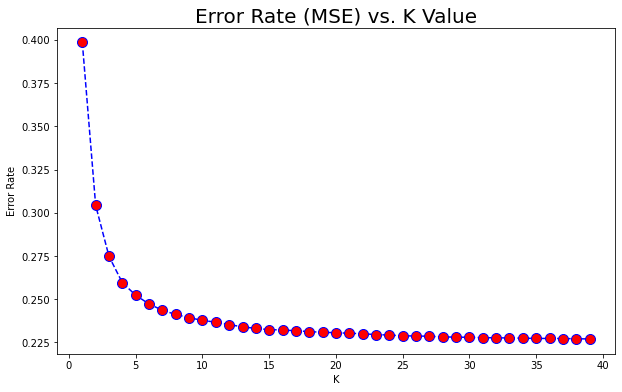

In [28]:
error = []

for i in range(1,40):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error.append(mean_squared_error(y_test, pred_i))
    
# Visualise error rate to see where it tapers off
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate (MSE) vs. K Value', fontsize = 20)
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

#### 3.4.2 Train Model & Inspect Performance on Test Set

Pass the best parameters into KNN Regressor and obtain test score. 

In [29]:
# Running with optimized k
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train_reg,y_train_reg)

regression_scores(knn, X_train_reg, X_test_reg, y_train_reg, y_test_reg)

R2 train 0.51
Train MSE: 36.14

R2 test 0.44
Test MSE: 41.34


### 3.5 Regressor Evaluation & Selection<a class="anchor" id="section3.5"></a>

#### Best Performance: Random Forest Regressor

Overall, we should proceeed with Random Forest Regressor to predict offer redemption given as it has the highest overall $r^2$ and lowest error.

Each regressors' performance is summarised below, with best performance in green and worst in red. Test Set metrics are what are used for evaluation and Train Set is included for reference only.

<img src = "./images/regressor_results.png" width="600"/>


### 3.6 Findings: The Most Important Features Predicting Amount Spent<a class="anchor" id="section3.6"></a>

With opaque regressors like RandomForest, it is useful to use <b>permutation feature imporance</b> to see which features are most impactful. 

In a nutshell, this metric tells us which features, if present, are most likely to result in a better classification outcome. Refer to sklearn's insightful summary on [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html).

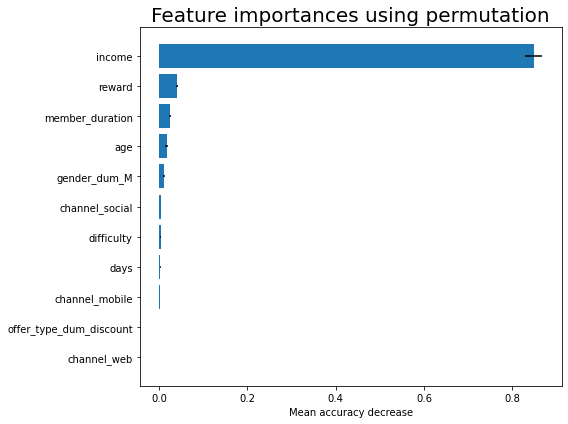

In [30]:
result = permutation_importance(
    rfr, X_test_reg, y_test_reg, n_repeats=10, random_state=42, n_jobs=-1
)

feature_names = [f"{i}" for i in X.columns]
importances = result.importances_mean
std = result.importances_std

my_dict = {'feature_names': feature_names, 'feature_impt': importances, 'std': std}

pi = pd.DataFrame.from_dict(my_dict)
pi.sort_values(by = 'feature_impt', ascending = False, inplace = True)

# Visualize feature importances
fig, ax = plt.subplots(figsize=[8,6])
plt.barh(y = pi['feature_names'], width = pi['feature_impt'], xerr=pi['std'])
ax.set_title("Feature importances using permutation", fontsize = 20)
ax.set_xlabel("Mean accuracy decrease")
ax.invert_yaxis()  # labels read top-to-bottom
fig.tight_layout()

#### The Most Important Feature Predicting Offer Completion

We can clearly see that the most important factor in determining amount spent is the individual's income. This has two important implications:

1. This underscores the importance of good data collection of the customer income feature, where legal
2. From a marketing perspective, this means <b>more targeted customer acquisition campaigns to high-income individuals</b> would be justified as they eventually will also spend more

## 4. Combined Expected Value Model<a class="anchor" id="section4"></a>

Following this we can apply both models to optimise the promotions sent to a specific customer.

For example, we can start with person id *ffe5257abf8840b395e1ee6b29894637* who is a 77 year old male, with 75,000 income and has been a member for 338 days. In the experiment, he received 5 promotions in a month of which only 1 was successful. He spent \$15.22 as a result of that successful buy-one-get-one offer.

In [31]:
df_all[df_all['person'] == 'ffe5257abf8840b395e1ee6b29894637'][['promo_name','success','amount']+features]

,promo_name,success,amount,age,income,member_duration,reward,difficulty,days,channel_web,channel_mobile,channel_social,gender_dum_M,offer_type_dum_discount
6172,disc-1,0,34.95,77,75000.0,338,2,10,9.00,1,1,0,1,1
12334,bogo-1,0,0.00,77,75000.0,338,5,5,17.75,1,1,1,1,0
43523,bogo-2,1,15.22,77,75000.0,338,5,5,15.50,1,1,0,1,0
49821,disc-4,0,34.95,77,75000.0,338,5,20,9.00,1,0,0,1,1
49822,disc-4,0,0.00,77,75000.0,338,5,20,21.00,1,0,0,1,1


### 4.1 Offer Ranking Using Trained Models<a class="anchor" id="section4.1"></a>

<b> Steps </b>
1. Demographic and promotions data first fed into the classifier to get $ P(OfferSuccess)$
2. The same features are then fed to the regressor to get $Expected Spend$
3. The promotions are then ranked by Expected Value ($P(OfferSuccess) * Expected Spend$)

<b> Assumptions </b>
- We should only serve the top 4 best promotions in a single month
    - This prevents brand equity dilution by restricting offers to just once per week
    - This preserves the mode number of offers sent in the current dataset (ranges from 1 to 10)
- We should not repeat promotions
    - Offer success probabilities may change for subsequent promotions of the same type, this has not been modelled here

In [32]:
example = pd.read_csv('data/example.csv')
example

,promo_name,age,income,member_duration,reward,difficulty,days,channel_web,channel_mobile,channel_social,gender_dum_M,offer_type_dum_discount
0,bogo-4,77,75000,338,10,10,15,0,1,1,1,0
1,bogo-3,77,75000,338,10,10,15,1,1,1,1,0
2,bogo-2,77,75000,338,5,5,15,1,1,0,1,0
3,disc-4,77,75000,338,5,20,15,1,0,0,1,1
4,disc-3,77,75000,338,3,7,15,1,1,1,1,1
5,disc-2,77,75000,338,2,10,15,1,1,1,1,1
6,bogo-1,77,75000,338,5,5,15,1,1,1,1,0
7,disc-1,77,75000,338,2,10,15,1,1,0,1,1


<b>Step 1:</b> Demographic and promotions data first fed into the classifier to get  𝑃(𝑂𝑓𝑓𝑒𝑟𝑆𝑢𝑐𝑐𝑒𝑠𝑠)

In [33]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

example_p_offer_success = xgb.predict_proba(example.iloc[:,1:])# Exclude promo_name from features 
example_p_offer_success = example_p_offer_success[:,1] # Take only the probability of class 1 i.e. offer success = True 
example_p_offer_success

array([0.41, 0.46, 0.34, 0.27, 0.63, 0.61, 0.49, 0.33], dtype=float32)

<b>Step 2:</b> The same features are then fed to the regressor to get  $𝐸𝑥𝑝𝑒𝑐𝑡𝑒𝑑𝑆𝑝𝑒𝑛𝑑$

In [34]:
example_exp_spend = rfr.predict(example.iloc[:,1:])# Exclude promo_name from features 
example_exp_spend

array([19.74, 19.63, 19.63, 20.40, 19.33, 19.43, 18.82, 19.98])

<b>Step 3:</b> The promotions are then ranked by Expected Value ($P(OfferSuccess) * Expected Spend$)

In [35]:
ranking = example[['promo_name']]
ranking['P(Offer Success)'] = example_p_offer_success
ranking['Expected Spend'] = example_exp_spend
ranking['P(Offer Success) x Expected Spend'] = ranking['P(Offer Success)'] * ranking['Expected Spend']
ranking

,promo_name,P(Offer Success),Expected Spend,P(Offer Success) x Expected Spend
0,bogo-4,0.406683,19.743503,8.029352
1,bogo-3,0.461236,19.629418,9.053791
2,bogo-2,0.339964,19.631866,6.674131
3,disc-4,0.265187,20.404650,5.411046
4,disc-3,0.628778,19.328527,12.153360
5,disc-2,0.608454,19.434354,11.824909
6,bogo-1,0.494991,18.822586,9.317015
7,disc-1,0.333459,19.984149,6.663903


<b>Final Result</b>: The top 4 offers to be served are as disc-3, disc-2, bogo-1 and bogo-3

In [36]:
# Sort promo_name by score
ranking.sort_values('P(Offer Success) x Expected Spend', ascending = False).iloc[0:4]

,promo_name,P(Offer Success),Expected Spend,P(Offer Success) x Expected Spend
4,disc-3,0.628778,19.328527,12.153360
5,disc-2,0.608454,19.434354,11.824909
6,bogo-1,0.494991,18.822586,9.317015
1,bogo-3,0.461236,19.629418,9.053791
